In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

from locnet import LocNet

In [2]:
train, test = keras.datasets.mnist.load_data()
x_train, y_train = train
x_val, y_val = test

x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)

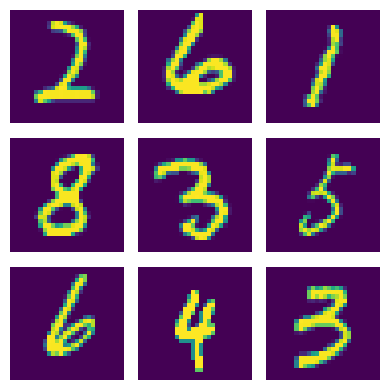

In [3]:
random_indices = np.random.choice(len(x_train), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(4, 4))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(x_train[random_indices[i]])
  ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
train_datagen = ImageDataGenerator(
  rescale=1./255,  
  rotation_range=20, 
  width_shift_range=0.2,  
  height_shift_range=0.2,
  zoom_range=0.2,  
  shear_range=0.2, 
  fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
  rescale=1./255,
)

train_set = train_datagen.flow(x_train, y_train, batch_size=32)
val_set = val_datagen.flow(x_val, y_val, batch_size=32)

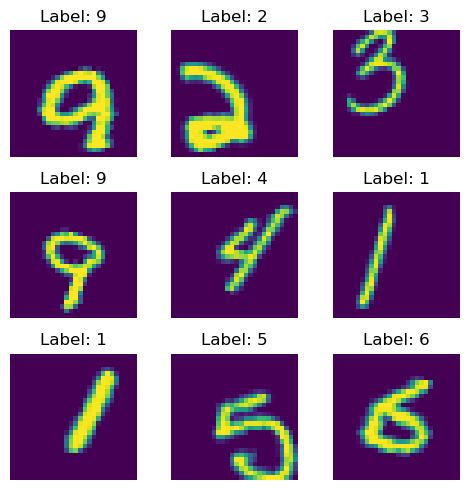

In [5]:
import matplotlib.pyplot as plt

batch_images, batch_labels = next(train_set)

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()
for i in range(9):
  image = batch_images[i]
  label = tf.argmax(batch_labels[i]).numpy()
  axes[i].imshow(image)
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import keras.losses
import keras.optimizers


def build_model(use_stn: bool = False):
  layer_sequence = [
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ]

  if use_stn:
    layer_sequence.insert(1, LocNet(image_width=28, image_height=28))
  
  model = keras.models.Sequential(layer_sequence)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
    loss=keras.losses.CategoricalCrossentropy(), 
    metrics=[
      keras.metrics.CategoricalAccuracy(),
      keras.metrics.Precision(),
      keras.metrics.Recall(),
    ]
  )

  return model

In [7]:
model = build_model(use_stn=False)
model.summary()
model.fit(train_set, validation_data=val_set, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [8]:
model = build_model(use_stn=True)
model.summary()
model.fit(train_set, validation_data=val_set, epochs=10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 loc_net (LocNet)            (None, 28, 28, 1)         40410     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)         

1/1 [==============================] - 0s 133ms/step


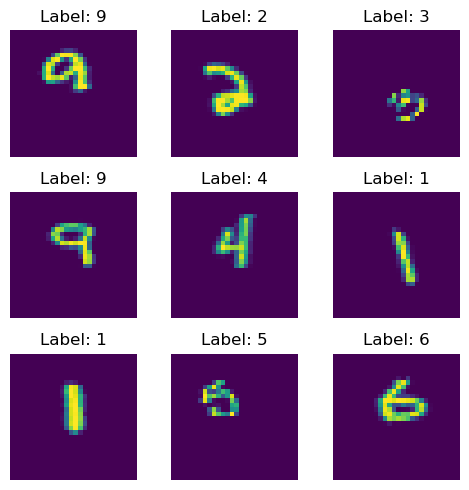

In [9]:
activation_model = keras.models.Model(inputs=model.input, outputs=model.layers[0].output)

activations = activation_model.predict(batch_images)

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()
for i in range(9):
  image = activations[i, :, :, 0]
  label = tf.argmax(batch_labels[i]).numpy()
  axes[i].imshow(image)
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()